In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Poisson

from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
file_global = 'spotifycharts_20170629to20180126_global.csv'
df = pd.read_csv(file_global)
df

,region,date,Position,Track Name,Artist,Streams,URL
0,global,2017-06-29,1,Despacito - Remix,Luis Fonsi,5945441,https://open.spotify.com/track/5CtI0qwDJkDQGwX...
1,global,2017-06-29,2,Wild Thoughts (feat. Rihanna & Bryson Tiller),DJ Khaled,4496288,https://open.spotify.com/track/1OAh8uOEOvTDqkK...
2,global,2017-06-29,3,"I'm the One (feat. Justin Bieber, Quavo, Chanc...",DJ Khaled,4291359,https://open.spotify.com/track/3DXncPQOG4VBw3Q...
3,global,2017-06-29,4,2U (feat. Justin Bieber),David Guetta,3849460,https://open.spotify.com/track/3A7qX2QjDlPnazU...
4,global,2017-06-29,5,Shape of You,Ed Sheeran,3492692,https://open.spotify.com/track/7qiZfU4dY1lWllz...
...,...,...,...,...,...,...,...
42377,global,2018-01-26,196,Redbone,Childish Gambino,623117,https://open.spotify.com/track/3kxfsdsCpFgN412...
42378,global,2018-01-26,197,The Weekend - Funk Wav Remix,SZA,614714,https://open.spotify.com/track/0P6AWOA4LG1XOct...
42379,global,2018-01-26,198,Stay,Zedd,612468,https://open.spotify.com/track/0I20rLT2MJDhcF9...
42380,global,2018-01-26,199,From Now On,Hugh Jackman,610407,https://open.spotify.com/track/3IkWmgGsXbsafru...


(a)

In [3]:
# aggregate by date and sum number of streams, drop position, reset index
df_day = df[['date', 'Streams']].groupby('date').sum().reset_index()
df_day

,date,Streams
0,2017-06-29,211404206
1,2017-06-30,225127214
2,2017-07-01,215525326
3,2017-07-02,187289761
4,2017-07-03,202298369
...,...,...
207,2018-01-22,214250426
208,2018-01-23,218584400
209,2018-01-24,221318148
210,2018-01-25,222680611


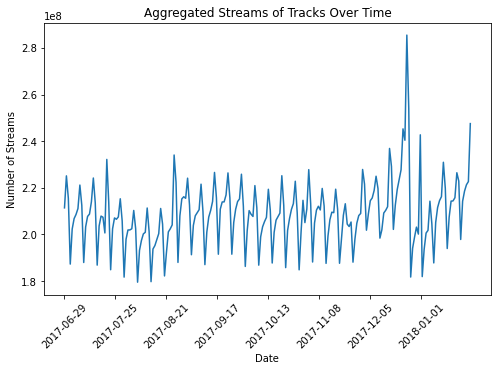

In [4]:
# plot streams of all tracks over time
plt.figure(figsize=(8,5))
plt.plot(df_day['date'], df_day['Streams'])
vals = np.arange(0, 212, step=212/8)
plt.xticks(vals, rotation=45)
plt.title('Aggregated Streams of Tracks Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Streams')
plt.show()

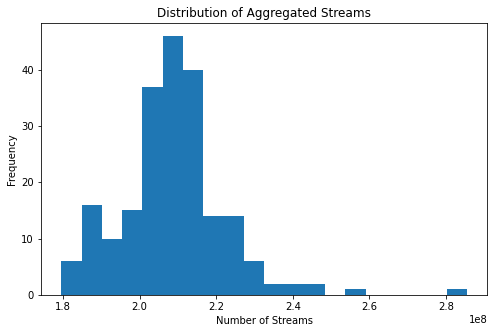

In [5]:
# look at distribution of aggregated streams
plt.figure(figsize=(8,5))
plt.hist(df_day['Streams'], bins=20)
plt.xlim()
plt.title('Distribution of Aggregated Streams')
plt.xlabel('Number of Streams')
plt.ylabel('Frequency')
plt.show()

Despite the streams of individual tracks being heavily right-skewed in part 1, the distribtuion of aggregated streams is roughly normally distributed. There is thus no need to transform it.

To test for time effects, we'll add day fixed effects and a holiday indicator variable and then run a regression with the necessary variables.

In [6]:
# convert date to datetime
df_day['date'] = pd.to_datetime(df_day['date'], format='%Y-%m-%d')

# add day fixed effects
df_day['Day of Week'] = df_day['date'].dt.day_name() # get day of week
df_day = pd.get_dummies(df_day, columns=['Day of Week'], prefix='d')
df_day = df_day.drop(columns=['d_Sunday'])

# add holiday dummy
cal = calendar()
holidays = cal.holidays(start=df_day['date'].min(), end=df_day['date'].max())
# 2017-10-09 and 2018-01-15 are not holidays; 2017-10-31 is
holidays = list(holidays) # convert to list for mutability
holidays.remove(pd.to_datetime('2017-10-09', format='%Y-%m-%d'))
holidays.remove(pd.to_datetime('2018-01-15', format='%Y-%m-%d'))
holidays.append(pd.to_datetime('2017-10-31', format='%Y-%m-%d'))
df_day['Holiday'] = df_day['date'].isin(holidays).astype(int)

In [7]:
# we need numeric regressors, so let's make a date index
df_day['tIndex'] = [i+1 for i in range(len(df_day))]

### LINEAR REGRESSION ###
day_fe = [col for col in df_day.columns if col.startswith('d_')]
X = df_day[['tIndex', 'Holiday'] + day_fe]
y = df_day['Streams']
X = sm.add_constant(X)
lr = sm.OLS(y, X)
results_lr = lr.fit()
print(results_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                Streams   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     18.84
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           4.95e-21
Time:                        12:00:54   Log-Likelihood:                -3728.3
No. Observations:                 212   AIC:                             7475.
Df Residuals:                     203   BIC:                             7505.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.881e+08   2.34e+06     80.489      

In [8]:
### POISSON REGRESSION ###
pos = Poisson()
formula = "Streams ~ tIndex + Holiday + d_Friday + d_Saturday + d_Monday + d_Tuesday + d_Wednesday + d_Thursday"
pr = GEE.from_formula(formula=formula, groups="date", data=df_day, family=pos)
results_pr = pr.fit()
print(results_pr.summary())

                               GEE Regression Results                              
Dep. Variable:                     Streams   No. Observations:                  212
Model:                                 GEE   No. clusters:                      212
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                    60
Date:                     Wed, 08 Dec 2021   Scale:                           1.000
Covariance type:                    robust   Time:                         12:00:58
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      19.0549      0.015   1305.453      0.000      19.026      19.084
tInd

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1252: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)


(b)

In [9]:
# subset original data to contain only the top 50 tracks
df_50 = df[df['Position'] <= 50]
# aggregate by date and sum number of streams, drop position, reset index
df_day_50 = df_50[['date', 'Streams']].groupby('date').sum().reset_index()
df_day_50

,date,Streams
0,2017-06-29,112192765
1,2017-06-30,118481026
2,2017-07-01,114889131
3,2017-07-02,99894562
4,2017-07-03,108215752
...,...,...
207,2018-01-22,101329207
208,2018-01-23,103415912
209,2018-01-24,104868439
210,2018-01-25,105057412


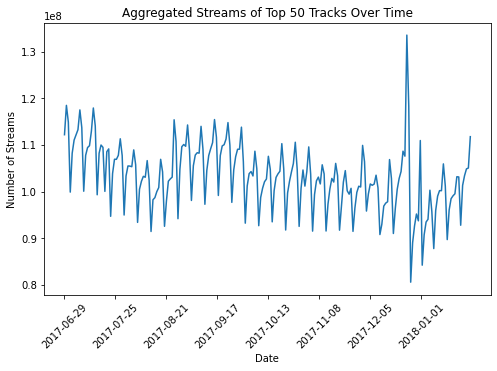

In [10]:
# plot streams of top 50 tracks over time
plt.figure(figsize=(8,5))
plt.plot(df_day_50['date'], df_day_50['Streams'])
vals = np.arange(0, 212, step=212/8)
plt.xticks(vals, rotation=45)
plt.title('Aggregated Streams of Top 50 Tracks Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Streams')
plt.show()

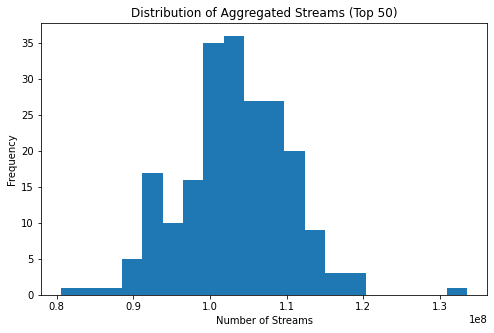

In [11]:
# look at distribution of aggregated streams
plt.figure(figsize=(8,5))
plt.hist(df_day_50['Streams'], bins=20)
plt.xlim()
plt.title('Distribution of Aggregated Streams (Top 50)')
plt.xlabel('Number of Streams')
plt.ylabel('Frequency')
plt.show()

In [12]:
# convert date to datetime
df_day_50['date'] = pd.to_datetime(df_day_50['date'], format='%Y-%m-%d')

# add day fixed effects
df_day_50['Day of Week'] = df_day_50['date'].dt.day_name() # get day of week
df_day_50 = pd.get_dummies(df_day_50, columns=['Day of Week'], prefix='d')
df_day_50 = df_day_50.drop(columns=['d_Sunday'])

# add holiday dummy
cal = calendar()
holidays = cal.holidays(start=df_day_50['date'].min(), end=df_day['date'].max())
# 2017-10-09 and 2018-01-15 are not holidays; 2017-10-31 is
holidays = list(holidays) # convert to list for mutability
holidays.remove(pd.to_datetime('2017-10-09', format='%Y-%m-%d'))
holidays.remove(pd.to_datetime('2018-01-15', format='%Y-%m-%d'))
holidays.append(pd.to_datetime('2017-10-31', format='%Y-%m-%d'))
df_day_50['Holiday'] = df_day_50['date'].isin(holidays).astype(int)

In [13]:
# we need numeric regressors, so let's make a date index
df_day_50['tIndex'] = [i+1 for i in range(len(df_day_50))]

### LINEAR REGRESSION ###
day_fe = [col for col in df_day.columns if col.startswith('d_')]
X = df_day_50[['tIndex', 'Holiday'] + day_fe]
y = df_day_50['Streams']
X = sm.add_constant(X)
lr = sm.OLS(y, X)
results_lr = lr.fit()
print(results_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                Streams   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     22.77
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           1.18e-24
Time:                        10:43:29   Log-Likelihood:                -3575.5
No. Observations:                 212   AIC:                             7169.
Df Residuals:                     203   BIC:                             7199.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.009e+08   1.14e+06     88.757      

In [14]:
### POISSON REGRESSION ###
pos = Poisson()
formula = "Streams ~ tIndex + Holiday + d_Friday + d_Saturday + d_Monday + d_Tuesday + d_Wednesday + d_Thursday"
pr = GEE.from_formula(formula=formula, groups="date", data=df_day_50, family=pos)
results_pr = pr.fit()
print(results_pr.summary())

                               GEE Regression Results                              
Dep. Variable:                     Streams   No. Observations:                  212
Model:                                 GEE   No. clusters:                      212
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                    60
Date:                     Thu, 18 Nov 2021   Scale:                           1.000
Covariance type:                    robust   Time:                         10:43:30
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      18.4269      0.014   1328.488      0.000      18.400      18.454
tInd

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1252: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)
